In [55]:
library(tidyverse)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(taxyvr)
library(cowplot)
install.packages("formattable")
library(formattable)
install.packages("simpleboot")
library(simpleboot)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



# Investigation into Median Data Science Salaries

## INTRODUCTION

Increased use of data in decision-making across the economy has resulted in strong demand for those with Data Science qualifications.  Having witnessed a 650% increase in the last decade, employment growth is projected to be 31.4% from 2020 to 2030 (Zair, C. 2021; Data Science Jobs Guide).  Given this buoyant outlook, what can Data Science professionals expect salary wise? In addition, the onset of COVID-19 has accelerated the prevalence of remote work, with fully remote teams increasing from 2.3% to 20% of total teams from pre-2019 to 2020 (Ozimek, 2020); we will explore whether there is a salary difference in remote-majority vs minority positions. To accommodate for the right-skew of our sample distributions, our project will investigate the median salary, median absolute deviation, and interquartile range of full-time Data Science professionals in the United States. Our report utilizes a dataset from Kaggle comprising of salary and other employment information anonymously submitted by Data Science professionals.

#### Note on terms used:

(1) remote-minorty position (remote_min): Less than 20% of the overall amount of work done remotely for position.

(2) remote-majority position (remote_maj): More than 80% of the overall amount of work done remotely for position.

(3) USD: United States Dollars

## METHODS AND RESULTS

### METHODS

Information within the dataset is self-reported, hence there is potential for selection bias.  However, because the submissions are anonymous, overall we may rely on the truthfulness of the submissions.  The data provides a reasonable number of observations (approximately 350) and is current (from 2020 to 2022). 

Performing a preliminary investigation, USD 140,000 was obtained as an estimate for the median income of full-time US Data Science professionals.  Our investigation also found that the median income for those working in remote-majority positions is USD 140,000 whereas the median income for those in remote-minority positions is USD 130,000.  On the basis of this preliminary investigation, it appears professionals in remote-majority positions can expect a higher salary than their remote-minority counterparts.
 
However, noting the two groups have substantial overlap in their interquartile range, that their medians are close to each other, and the presence of randomness and other confounding factors, this assessment is not sufficient to make definite conclusions on median salaries.  We will thus utilize bootstrapping of the sample to produce a 90% confidence interval of the estimated median salary for full time Data Science professionals working in the US. 

Bootstrapping methods, rather than asymptotics, are appropriate for this investigation, given that we are invesigating median salaries.  If we had instead decided to investigate mean salaries, and assuming requirements for Central Limit Theory were met, asymptotics may have been the preferred method. 
 
In addition, we will conduct two hypothesis tests at the 10% significance level.  The first will be to further investigate whether there is a true difference in median salaries, with our null hypothesis being that there is no difference in median pay between Data Science professionals employed remotely-majority compared to remote-minority positions.  Our alternative hypothesis is that there is a difference in median income between these two groups.

The second hypothesis test will be whether the true median income for Data Science professionals is USD 98,230, as reported by US News and World Report. The null hypothesis is that the true median income is the aforementioned pay, with our alternative hypothesis being that the true median is different from USD 98,230.
 
We expect to find a statistically significant difference in the true median income between remote-minority vs remote-majority Data Science professionals. We hope this investigation will assist Data Science professionals better assess their income opportunities. Additionally, considering remote employees have reported to be significantly happier than their non-remote counterparts (Elshaiekh et al., 2018), we hope this report will provide the salary insights necessary to inform decisions whether to pursue a remote vs non-remote career. Future questions would likely include whether confounding factors influenced differences in median salary observed and salary trends.

### RESULTS

#### 1. Prelinary Results
##### **Table 1.1** Orignal Data

In [56]:
original_data <- read_csv("ds_salaries.csv")
head(original_data)

New names:
• `` -> `...1`
Rows: 607 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (7): experience_level, employment_type, job_title, salary_currency, empl...
dbl (5): ...1, work_year, salary, salary_in_usd, remote_ratio

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<chr>
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
5,2020,EN,FT,Data Analyst,72000,USD,72000,US,100,US,L


##### **Table 1.2** Clean Data

In [57]:
# Cleaning the data to only show US residence, 0 and 100 remote ratio 
# and Full Time employment

clean_data <- original_data %>%
    filter(!is.na(salary_in_usd),
        employee_residence == "US",
            employment_type == "FT", 
        remote_ratio %in% c(0, 100)) %>%
    select(experience_level, salary_in_usd, remote_ratio)

head(clean_data)

experience_level,salary_in_usd,remote_ratio
<chr>,<dbl>,<dbl>
EN,72000,100
SE,190000,100
MI,135000,100
MI,87000,100
MI,85000,100
MI,98000,0


##### **Table 1.3** Calculations for summary data (min, max, median, mean, amount) related ot the different groups being explored.

In [58]:
remote_min_dist <-
    clean_data %>%
    filter(remote_ratio == 0)

remote_maj_dist <-
    clean_data %>%
    filter(remote_ratio == 100)

remote_min_median <- remote_min_dist %>% 
    summarise(median_0 = median(salary_in_usd)) %>%
    pull()

remote_maj_median <- remote_maj_dist %>% 
    summarise(median_100 = median(salary_in_usd)) %>%
    pull()

remote_min_mean <- remote_min_dist %>%
    summarise(mean_0 = mean(salary_in_usd)) %>%
    pull() %>%
    ceiling()

remote_maj_mean <- remote_maj_dist %>%
    summarise(mean_100 = mean(salary_in_usd)) %>%
    pull() %>%
    ceiling()

remote_min_min <- remote_min_dist %>%
    summarise(min_0 = min(salary_in_usd)) %>%
    pull()


remote_min_max <- remote_min_dist %>%
    summarise(min_0 = max(salary_in_usd)) %>%
    pull()

remote_min_amount <- 
    clean_data %>%
    summarise(amount_0 = sum(remote_ratio == 0)) %>%
    pull()

remote_maj_min <- 
    clean_data %>%
    filter(remote_ratio == 100) %>%
    summarise(min_100 = min(salary_in_usd)) %>%
    pull()

remote_maj_max <- remote_maj_dist %>%
    summarise(max_100 = max(salary_in_usd)) %>%
    pull()

remote_maj_amount <- 
    clean_data %>%
    summarise(amount_100 = sum(remote_ratio == 100)) %>%
    pull()

overall_mean <-
    clean_data %>%
    summarise(overall_mean = mean(salary_in_usd)) %>%
    pull() %>%
    ceiling()

overall_median <-
    clean_data %>%
    summarise(overall_median = median(salary_in_usd)) %>%
    pull()

overall_min <-
    clean_data %>%
    summarise(overall_min = min(salary_in_usd)) %>%
    pull()

overall_max <- 
    clean_data %>%
    summarise(overall_max = max(salary_in_usd)) %>%
    pull()

overall_amount <- remote_min_amount + remote_maj_amount

##### Scaling Parameters: Calculating MAD and Inter-quartile Range
Following cell includes operations to calculate the Median Absolute Deviation (MAD) and Interquartile Range for:

(1) datascientists overall
(2) remote-minority data scientists
(3) remote-majority data scientists

In [59]:
overall_mad <- mad(clean_data$salary_in_usd) %>% ceiling()

remote_min_mad <- mad(remote_min_dist$salary_in_usd) %>% ceiling()

remote_maj_mad <- mad(remote_maj_dist$salary_in_usd) %>% ceiling()

remote_min_quartile_1 <- quantile(pull(remote_min_dist, salary_in_usd), 0.25)
remote_min_quartile_3 <- quantile(pull(remote_min_dist, salary_in_usd), 0.75)
remote_maj_quartile_1 <- quantile(pull(remote_maj_dist, salary_in_usd), 0.25)
remote_maj_quartile_3 <- quantile(pull(remote_maj_dist, salary_in_usd), 0.75)
overall_quartile_1 <- quantile(pull(clean_data, salary_in_usd), 0.25)
overall_quartile_3 <- quantile(pull(clean_data, salary_in_usd), 0.75)

#### The following operations build a summary table

In [60]:
categories <- c("remote minority", "remote majority", "overall")
min <- c(remote_min_min, remote_maj_min, overall_min)
max <- c(remote_min_max, remote_maj_max, overall_max)
mean <- c(remote_min_mean, remote_maj_mean, overall_mean)
median <- c(remote_min_median, remote_maj_median, overall_median)
frequency <- c(remote_min_amount, remote_maj_amount, overall_amount)
first_quartile <- c(remote_min_quartile_1, remote_maj_quartile_1, overall_quartile_1)
third_quartile <- c(remote_min_quartile_3, remote_maj_quartile_3, overall_quartile_3)
median_absolute_deviation <- c(remote_min_mad, remote_maj_mad, overall_mad)

ratio_data_frame <- data.frame(categories, min, max, mean, median, first_quartile, third_quartile, median_absolute_deviation, frequency)

summary_table <- formattable(ratio_data_frame, align = c("l", rep("r", NCOL(ratio_data_frame) -1)))

##### **Table 1.4** Table of Summary Statistics

In [61]:
summary_table

categories,min,max,mean,median,first_quartile,third_quartile,median_absolute_deviation,frequency
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
remote minority,54000,450000,141254,130000,99050,172500,51076,67
remote majority,25000,600000,150821,140000,110000,175000,47785,244
overall,25000,600000,148760,140000,106260,175000,50409,311


### Comment on Summary Statistics

Remote-minority positions have an estimated median salary that is lower than remote-majority's estimated median salary. The mean salary for each group is significantly greater than the median, indicating that salaries for each group skew to the right, with some jobs commanding lofty salaries. 

The two groups have similar spread, with the interquartile range of remote-minority and remote-majority positions being USD 73450 and USD 65000, respectively. Additionally, their median absolute deviations are in close range of each other.  Interpreting median absolute deviation, 50% of remote-minority Data Science professionals make between USD 78924 and USD 181076, 50% of remote-majority professionals make between USD 92215 and USD 187785, and 50% of Data Science professionals (overall) make between USD 89591 and USD 190409.

In [62]:
min_shade <- tibble(lower_bound <- (remote_min_median - remote_min_mad)/1000, upper_bound <- (remote_min_median + remote_min_mad)/1000)
maj_shade <- tibble(lower_bound <- (remote_maj_median - remote_maj_mad)/1000, upper_bound <- (remote_maj_median + remote_maj_mad)/1000)
overall_shade <- tibble(lower_bound <- (overall_median - overall_mad)/1000, upper_bound <- (overall_median + overall_mad)/1000)

remote_min_plot <-
    remote_min_dist %>%
    ggplot(aes(x = salary_in_usd/1000)) + 
    geom_histogram(binwidth = 20, color="white", fill="darkgoldenrod1") +
    geom_vline(xintercept = remote_min_median/1000, color="red", size=2) +
    shade_confidence_interval(min_shade, fill="lightblue") +
    xlab("salary in thousands of USD") +
    ggtitle("Salaries of Professionals in Remote Minority Workplaces")

remote_maj_plot <-
    remote_maj_dist %>%
    ggplot(aes(x = salary_in_usd/1000)) + 
    geom_histogram(binwidth = 20, color="white", fill="purple") +
    geom_vline(xintercept = remote_maj_median/1000, color="red", size=2) +
    shade_confidence_interval(overall_shade, fill="lightblue") +
    xlab("salary in thousands of USD") +
    ggtitle("Salaries of Professionals in Remote Majority Workplaces")


overall_plot <-
    clean_data %>%
    ggplot(aes(x = salary_in_usd/1000)) +
    geom_histogram(binwidth = 20, color="white", fill="skyblue") +
    geom_vline(xintercept = overall_median/1000, color="red", size=2) +
    shade_confidence_interval(overall_shade, fill="lightblue") +
    xlab("salary in thousands of USD") +
    ggtitle("Salary Distribution of Data Science Professionals")

##### **Figure 1.1** Histograms Illustrating Distributions of Salary

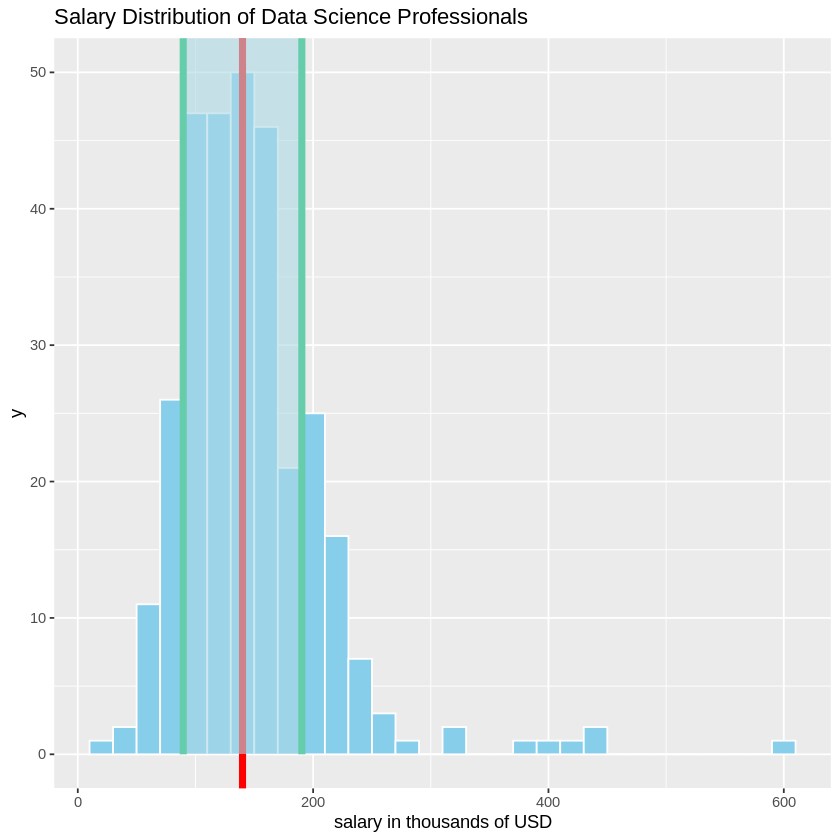

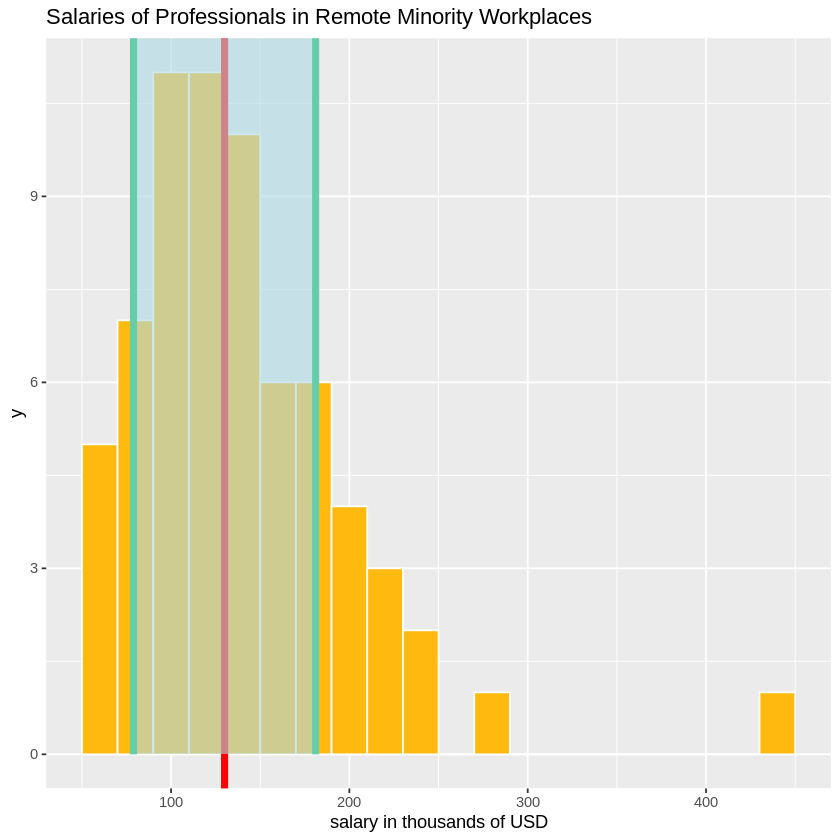

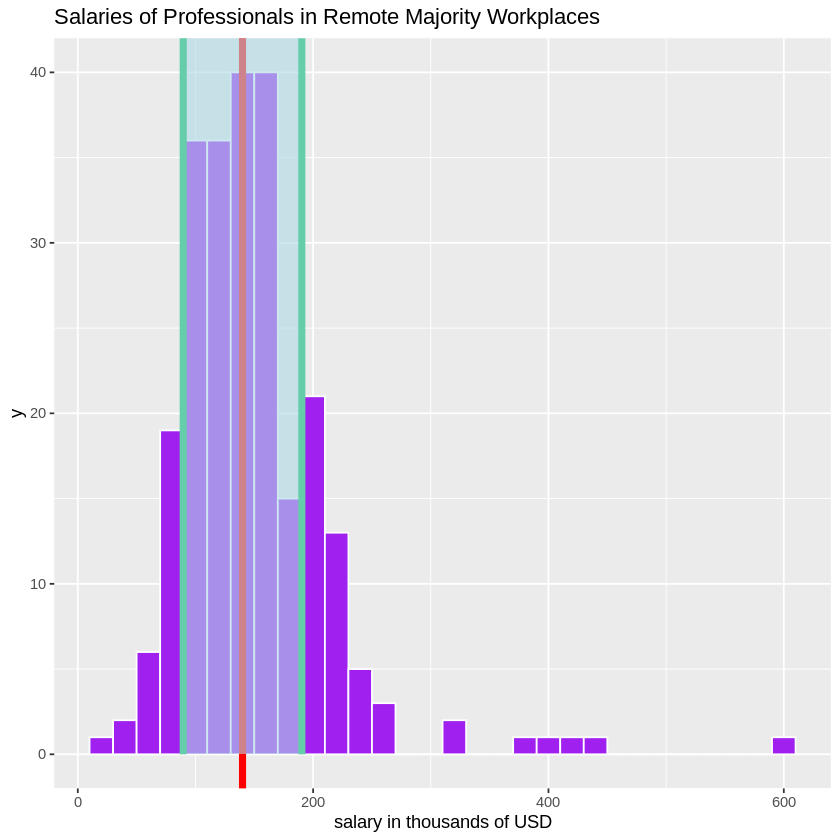

In [63]:
overall_plot
remote_min_plot
remote_maj_plot

In [64]:
# Boxplots of the data for ease of comparison

clean_data$remote_predominance <- factor(clean_data$remote_ratio,
                                levels=c(0, 100),
                                labels=c("remote minority", "remote majority"))

remote_ratio_boxplot <- 
    clean_data %>%
    ggplot(aes(y = salary_in_usd/1000, x = remote_predominance, fill=remote_predominance)) +
    geom_boxplot() +
    coord_cartesian(ylim = c(20, 600)) + 
    xlab("category of workplace (remote minority vs majority)") +
    ylab("salary (in thousands of US$)") +
    ggtitle("Salary Distribution for Data Science Professionals by Remote Category")

##### **Figure 1.2** Boxplot of Salary Distribution by Remote Category

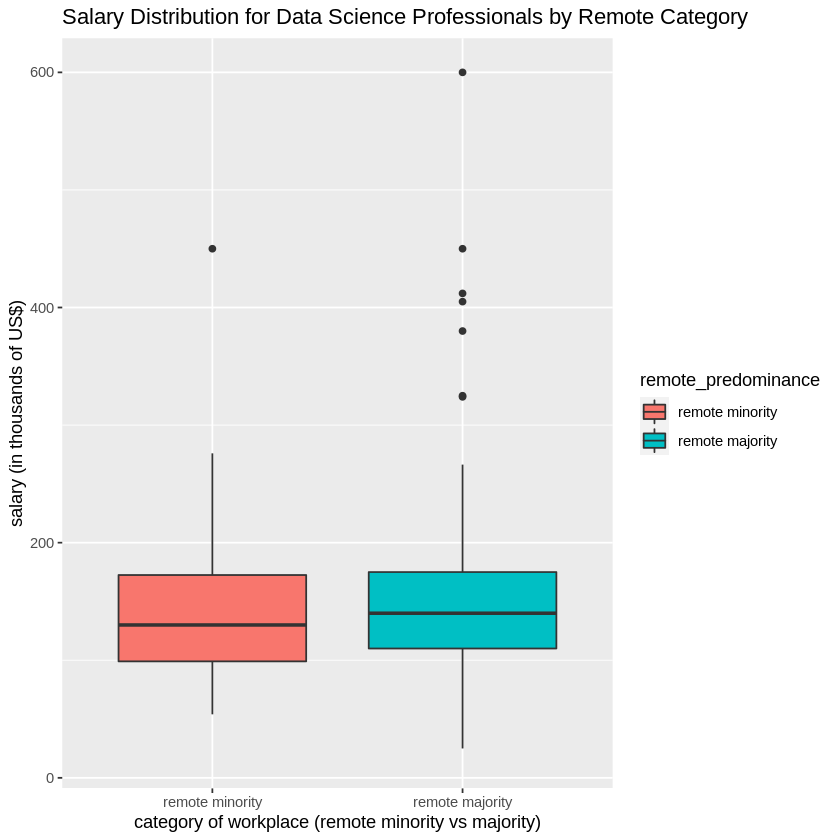

In [65]:
remote_ratio_boxplot

#### 2. Bootstrap Distributions

#### Bootstrap Distribution for Data Scientists (overall)

In [66]:
ds_workers <- original_data %>%
    filter(!is.na(salary_in_usd),
        employee_residence == "US",
            employment_type == "FT") %>%
    select(experience_level, salary_in_usd, remote_ratio)

##### **Table 2.1** Data Scientists Overall

In [67]:
ds_workers_median <- 140000/1000

ds_workers_bootstrap_dist <-
    ds_workers %>%
    specify(response = salary_in_usd) %>%
    generate(type="bootstrap", reps = 5000) %>%
    calculate(stat = "median")

head(ds_workers_bootstrap_dist)

replicate,stat
<int>,<dbl>
1,136620.0
2,135997.0
3,139175.0
4,140000.0
5,140000.0
6,137067.5


##### **Table 2.2** 90% Confidence Interval for Bootstrap Distribution of Data Scientists (overall)

In [68]:
ds_workers_ci <-
    ds_workers_bootstrap_dist %>%
    get_confidence_interval(level = 0.90, type = "percentile")

ds_workers_ci1 <- ds_workers_ci %>%
                  tibble(lower_ci1 = ds_workers_ci[[1]]/1000,  upper_ci1 = ds_workers_ci[[2]]/1000)%>%
                  select(lower_ci1, upper_ci1)

ds_workers_ci1 

lower_ci1,upper_ci1
<dbl>,<dbl>
135,144


We have 90% confidence that the true median salary for Data Scientists (overall) lies somewhere between USD 135000 and USD 144000. Note that the Null Hypothesis median salary of USD 98230 is not contained within this interval.

##### **Figure 2.1** Histogram of Bootstrap Distribution with 90% Confidence Interval for Data Scientists (overall)

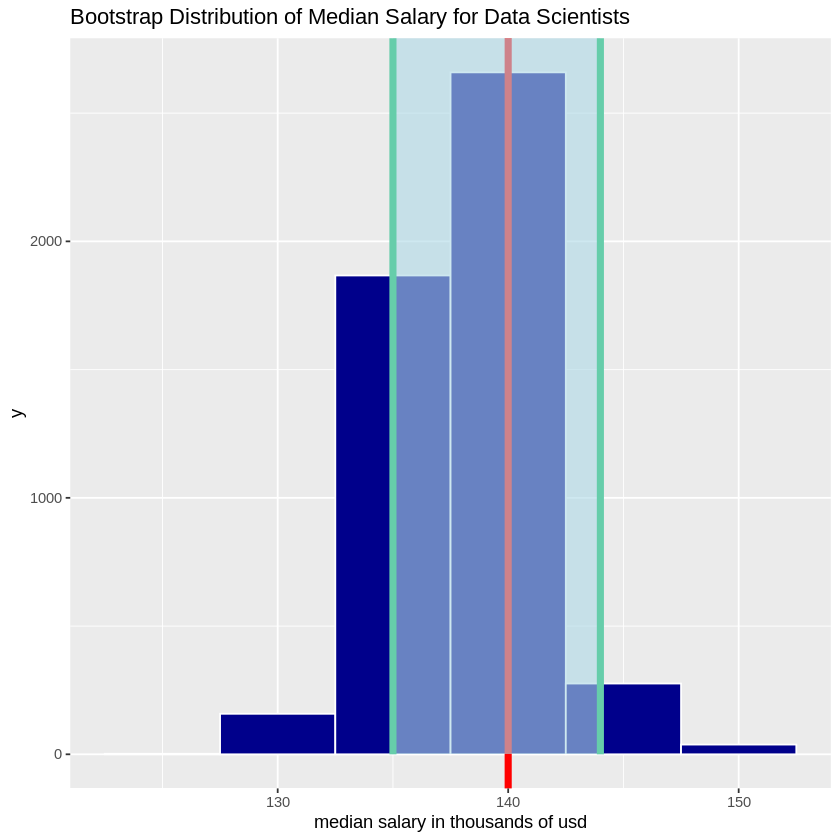

In [69]:
ds_workers_bootstrap_plot <-
    ds_workers_bootstrap_dist %>%
    ggplot(aes(x = stat/1000)) +
    geom_histogram(binwidth = 5, color="white", fill="darkblue" ) +
    geom_vline(size = 2, xintercept = ds_workers_median, color="red") +
    shade_confidence_interval(ds_workers_ci1, fill = "lightblue") +
    xlab("median salary in thousands of usd") +
    ggtitle("Bootstrap Distribution of Median Salary for Data Scientists")

ds_workers_bootstrap_plot

##### **Table 2.3** Boostrap Distribution for Data Scientists (remote-minority)

In [70]:
remote_min_median <- 130000/1000

remote_min_bootstrap_dist <- 
    remote_min_dist %>%
    specify(response = salary_in_usd) %>%
    generate(type = "bootstrap", reps = 5000) %>%
    calculate(stat = "median")

head(remote_min_bootstrap_dist)

replicate,stat
<int>,<dbl>
1,140400
2,130000
3,129000
4,130000
5,136000
6,132000


##### **Table 2.4** 90% Confidence Interval for Bootstrap Distribution of Data Scientists (remote-minority)

In [71]:
remote_min_ci <-
    remote_min_bootstrap_dist %>%
    get_confidence_interval(level = 0.90, type="percentile")

remote_min_ci1 <- remote_min_ci %>%
                tibble(lower_ci1 =  remote_min_ci[[1]]/1000, upper_ci1 = remote_min_ci[[2]]/1000) %>%
                select(lower_ci1, upper_ci1)
remote_min_ci1

lower_ci1,upper_ci1
<dbl>,<dbl>
116,140.4


We have 90% confidence that the true median income for remote-minority Data Scientists lies somewhere between USD 116000 and USD 140400.

##### **Figure 2.2** Histogram of Bootstrap Distribution with 90% Confidence Interval for Data Scientists (remote-minority)

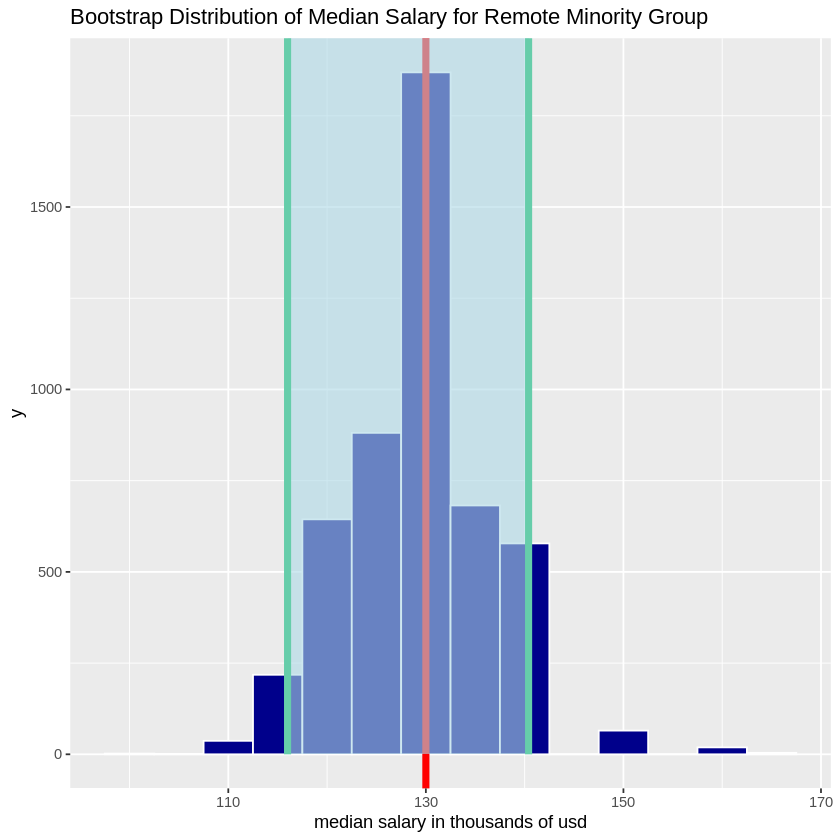

In [72]:
remote_min_bootstrap_plot <-
    remote_min_bootstrap_dist %>%
    ggplot(aes(x = stat/1000)) +
    geom_histogram(binwidth = 5, color="white", fill="darkblue" ) +
    geom_vline(size = 2, xintercept = remote_min_median, color="red") +
    shade_confidence_interval(remote_min_ci1, fill="lightblue") +
    xlab("median salary in thousands of usd") +
    ggtitle("Bootstrap Distribution of Median Salary for Remote Minority Group")

remote_min_bootstrap_plot

##### **Table 2.5** Bootstrap Distribution for Data Scientists (remote-majority)

In [73]:
remote_maj_median <- 140000/1000

remote_maj_bootstrap_dist <- 
    remote_maj_dist %>%
    specify(response = salary_in_usd) %>%
    generate(type = "bootstrap", reps = 5000) %>%
    calculate(stat = "median")

head(remote_maj_bootstrap_dist)

replicate,stat
<int>,<dbl>
1,135000
2,142000
3,140125
4,140000
5,140000
6,142125


##### **Table 2.6** 90% Confidence Interval for Bootstrap Distribution of Data Scientists (remote-majority)

In [74]:
remote_maj_ci <-
    remote_maj_bootstrap_dist %>%
    get_confidence_interval(level = 0.90, type="percentile")

remote_maj_ci1 <-
    remote_maj_ci %>%
    tibble(lower_ci1 = remote_maj_ci[[1]]/1000, upper_ci1 = remote_maj_ci[[2]]/1000)%>%
    select(lower_ci1, upper_ci1)

remote_maj_ci1

lower_ci1,upper_ci1
<dbl>,<dbl>
135,150


We have 90% confidence that the true median income for remote-majority Data Scientists lies somewhere between USD 135000 and USD 150000.

##### **Figure 2.3** Histogram of Bootstrap Distribution with 90% Confidence Interval for Data Scientists (remote-majority)

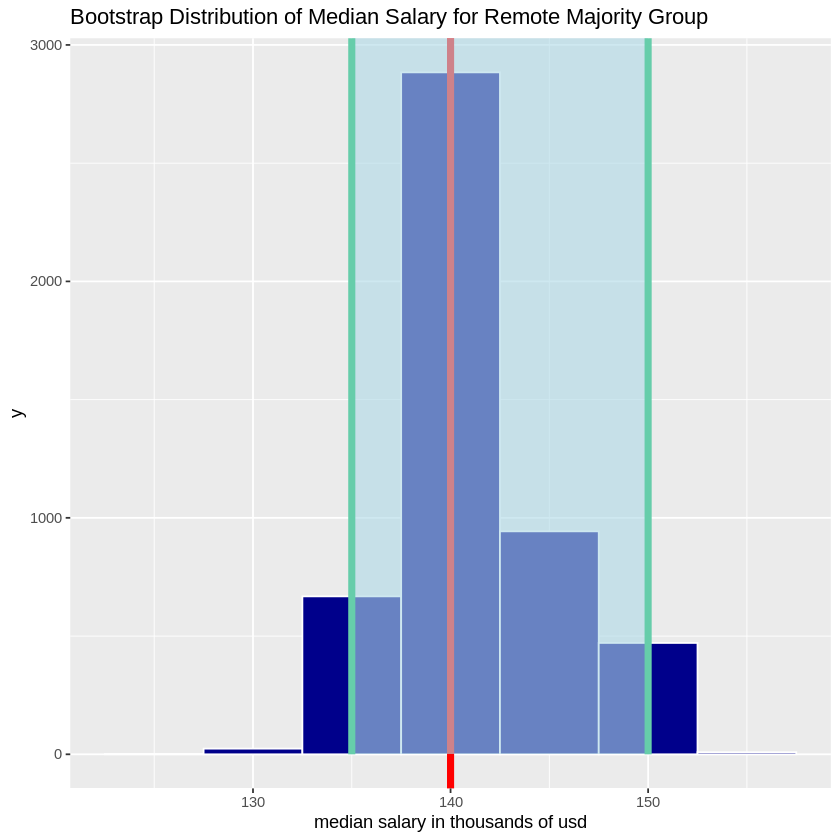

In [75]:
remote_maj_bootstrap_plot <-
    remote_maj_bootstrap_dist %>%
    ggplot(aes(x = stat/1000)) +
    geom_histogram(binwidth = 5, color="white", fill="darkblue" ) +
    geom_vline(size = 2, xintercept = remote_maj_median, color="red") +
    shade_confidence_interval(remote_maj_ci1, fill="lightblue") +
    xlab("median salary in thousands of usd") +
    ggtitle("Bootstrap Distribution of Median Salary for Remote Majority Group")

remote_maj_bootstrap_plot

#### 3. Hypotheses

##### Hypothesis Test 1: Comparing Remote-Majority and Remote-Minority Median Salaries

Null Hypothesis: full-time US remote-minority and remote-majority positions have the same median income.

Alternative Hypothesis: full-time US remote-minority and remote-majority positions have different median income.

The significance level is set to 10%; neither Type I or Type II errors are life-altering, and predominantly impact salary difference expectations of the reader, which may nevertheless be updated as they search and apply for data science positions. Hence, whether the significance level is set at 5% or 10% should not be of great consequence from a risk-management point of view.

##### Calculate the Observed Difference in Median Incomes

In [76]:
clean_data$remote_ratio <- as.factor(clean_data$remote_ratio)

obs_diff_in_medians <- 
    clean_data %>%
    specify(formula = salary_in_usd ~ remote_ratio) %>%
    calculate(stat = "diff in medians", order = c(100, 0))%>%
    mutate(stat = stat / 1000) %>%
    pull()

obs_diff_in_medians

[1] 10

The observed difference in median income between the two groups is USD 10000.

,bootstrapped_diff_in_medians.t
,<dbl>
1,5250.5
2,19175.0
3,8500.0
4,10000.0
5,-400.0
6,8125.0


[1] 0.4343

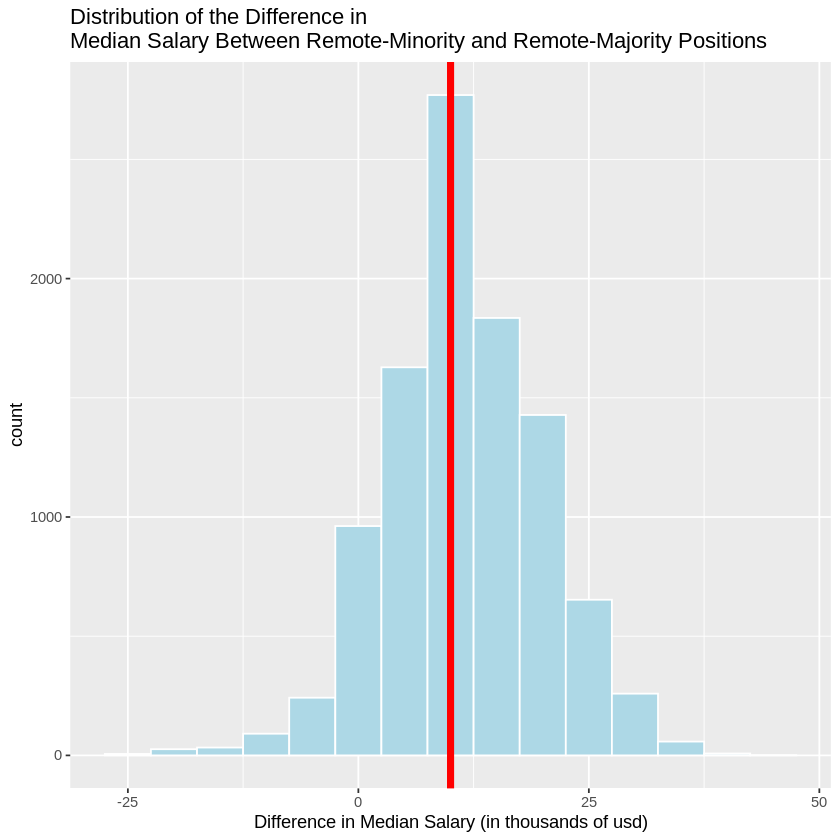

In [89]:
set.seed(50)

bootstrapped_diff_in_medians <- two.boot(remote_maj_dist$salary_in_usd, remote_min_dist$salary_in_usd, median, 10000)
bootstrapped_diff_in_median_df <- data.frame(bootstrapped_diff_in_medians$t)
head(bootstrapped_diff_in_median_df)
alternative_model_plot <- bootstrapped_diff_in_median_df %>%
                    ggplot(aes(x = bootstrapped_diff_in_medians.t/1000)) +
                    geom_histogram(binwidth = 5, color="white", fill="lightblue") +
                    geom_vline(size = 2, xintercept = obs_diff_in_medians, color="red") +
                    xlab("Difference in Median Salary (in thousands of usd)") +
                    ggtitle("Distribution of the Difference in 
Median Salary Between Remote-Minority and Remote-Majority Positions")

alternative_model_plot

p_value_type_2_error <- mean(bootstrapped_diff_in_median_df$bootstrapped_diff_in_medians.t/1000 < obs_diff_in_medians)
p_value_type_2_error

##### **Table 3.1** Create a Null Model for the Difference in Median Salaries

In [150]:
set.seed(50)

null_model<-
    clean_data %>%
    specify(formula = salary_in_usd ~ remote_ratio) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 10000, type = "permute") %>%
    calculate(stat = "diff in medians", order = c(100, 0))%>%
    mutate(stat = stat / 1000)

head(null_model)

replicate,stat
<int>,<dbl>
1,5.000
2,-0.825
3,2.000
4,7.805
5,10.400
6,-10.993


##### **Figure 3.1** Plot of Null Model with Observed Difference

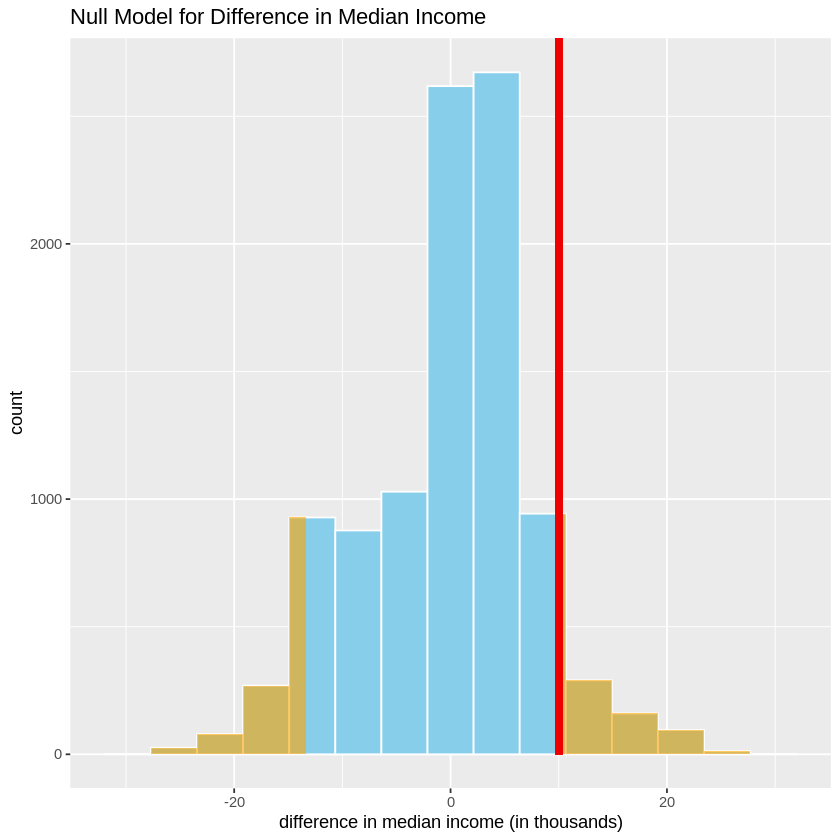

In [151]:
null_model_plot <- null_model %>%
                    visualize(fill = "skyblue") +
                    shade_p_value(obs_stat = obs_diff_in_medians, direction = "both", fill = "orange")+
                    xlab("difference in median income (in thousands)") +
                    ggtitle("Null Model for Difference in Median Income")

null_model_plot

##### p-value of observed difference assuming correctness of Null Model

In [152]:
p_value <- null_model %>%
    get_p_value(obs_stat = obs_diff_in_medians, direction = "both") %>%
    pull()

p_value

[1] 0.2002

#### Hypothesis 1: Discussion

The p-value observed (approximately 20%) is greater than the significance level of 10%. We therefore do not have sufficient evidence to reject the null hypothesis.  

Based on our research, there is not sufficient data to conclude that Data Scientists working in remote-minority positions make a different income from Data Scientists working in remote-majority positions. 

This is not what we expected to find; prior to conducting the study our expectation was that there would be some difference in median salary between the groups, likely with remote-minority positions in general offering higher salaries, in order to compensate and entice workers who would otherwise prefer the flexibility of remote-majority positions. 

Our study's results may be due to peculiarities of the dataset used; as mentioned in the Methods section, one of the concerns we had of our dataset is that its observations are self-reported and thus may suffer from selection-bias impacting the results.  However, it is also possible that there is something in the nature of Data Science work that, from an employer's perspective, there is little productivity difference from having employees work remotely versus onsite. It could also be the case that those professionals in remote-majority positions have greater career leverage than their remote-minority counterparts, and hence are able to enjoy the perks of remote-work without impact to their salary. 

Commission of Type II error is possible, i.e. we may be concluding that median income between remote-majority and remote-minority positions are the same when in reality there is a difference.  Committing this type of error may result in readers having the inaccurate belief that the mode of work (remote vs non-remote) has no impact on expected salary. Given that such beliefs can be updated as Data Science professionals search for jobs, and that job offers are accepted or declined on their individual merits, we do not perceive the consequences of committing a Type II error to be highly problematic.

Further research questions include whether this result is consistent across all levels of career progression amongst Data Science professionals, or whether there are observed median income differences for remote vs non-remote depending on experience and role type.  Relatedly, investigating whether different career levels have differences in the predominance of remote work positions might shed light our current findings.

#### Hypothesis Test 2: True Median Salary for Data Scientists (Overall)

Null Hypothesis: true median for full time, US Data Scientists is as stated in US News and World Report i.e. USD 98,230.

Alternative Hypothesis: true median for full time US Data Scientists is different than the figure stated by US News and World Report. 

Signifiance level is set to 10%.

##### **Table 3.2** Null Model for Data Science (overall) Median Salary

In [153]:
null_median <- 98230

overall_median_nullmodel <- ds_workers %>%
    specify(response = salary_in_usd) %>%
    hypothesise(null = "point", med = null_median) %>%
    generate(reps = 10000, type = "bootstrap") %>%
    calculate(stat = "median")
    
head(overall_median_nullmodel)    

replicate,stat
<int>,<dbl>
1,94755.0
2,96635.5
3,97325.5
4,94755.0
5,94755.0
6,94755.0


##### **Figure 3.2** Plot of Null Model with Observed Median Salary

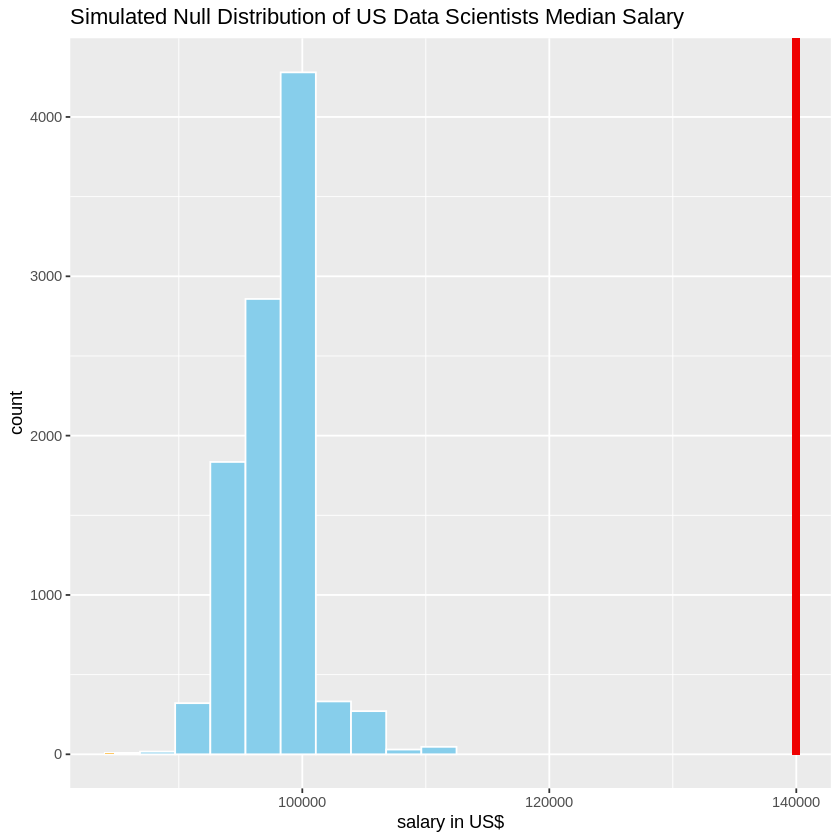

In [154]:
observed_median <- 140000 

overall_median_nullmodel_plot <- 
    overall_median_nullmodel %>%
    visualize(fill="skyblue", bins = 10) +
    shade_p_value(obs_stat = observed_median, direction = "both", fill = "orange") +
    xlab("salary in US$") +
    ggtitle("Simulated Null Distribution of US Data Scientists Median Salary")
    

overall_median_nullmodel_plot

In [155]:
# change right to both

overall_median_p_value <- 
    overall_median_nullmodel %>%
    get_p_value(obs_stat = observed_median, direction = "both") %>%
    pull()

overall_median_p_value

Warning message:
“Please be cautious in reporting a p-value of 0. This result is an approximation based on the number of `reps` chosen in the `generate()` step. See `?get_p_value()` for more information.”


[1] 0

#### Hypothesis 2: Discussion

Note that we interpret the p-value to mean a very low probability that is arbitrarily close to 0.

Based on the p-value, we reject the null hypothesis at a 10% significance level and conclude that, the median income observed from the dataset is not consistent with the median salary being USD 98230.

Having performed a preliminary investigation of the dataset, this result is not unexpected; the dataset's median salary value is substantially greater than that which is reported by US News and World Report (USD 140000 vs USD 98230), and so the observed median salary seemed to be inconsistent with a null model centered around USD 98230. 

This conclusion may result in commission of Type I error. The risk associated with this error is that readers may erroneously believe that the true median income of Data Scientists is significantly higher than what it truly is, and this may lead to lost career opportunities.  Specifically, readers may turn down reasonable job offers with market-rate compensations in the mistaken belief that such pay offers are much lower than their believed median salary.

Bearing that in mind, accepting this conclusion should be taken with caution, as there are limitations to the utilized dataset compared to the data used by US News and World Report.  US News and World Report utilizes data from the US Bureau of Labor Statistics, whose function is to collect employment-related data for the US federal government, and updates its data every quarter. The Bureau of Labor Statistics uses highly qualified economists, that use a variety of data collection methods, and is generally considered a reliable source for employment information.  In contrast, the dataset we used for this study is composed of self-reported observations, is subject to selection-bias, and thus may not be representative of Data Scientists as a whole. Hence, despite the low observed p-value from this study, we cannot say definitely that we have demonstrated that the true median salary of Data Scientists is not USD 98230.

### REFERENCES

Bhatia, R, (2022), Data Science Job Salaries, [Data set]. Kaggle. https://www.kaggle.com/datasets/ruchi798/data-science-job-salaries. 

Data Science Jobs Guide: Resources for a Career in Tech. (2022, July 21). Coursera. https://www.coursera.org/articles/data-science-jobs.

Elshaiekh, N. E. M., Hassan, Y. A. A., & Abdallah, A. A. A. (2018). The Impacts of Remote Working on Workers Performance. 2018 International Arab Conference on Information Technology (ACIT), 1–5. https://doi.org/10.1109/ACIT.2018.8672704

Ozimek, A. (2020). The Future of Remote Work. SSRN Electronic Journal. https://doi.org/10.2139/ssrn.3638597.

Zaire, C. (2021, November 8). Is Data Science Still a Rising Career in 2021. Towards Data Science. https://towardsdatascience.com/is-data-science-still-a-rising-career-in-2021-722281f7074c.

US News and World Report article on data science: https://money.usnews.com/careers/best-jobs/data-scientist